In [ ]:
pip install tensorflow_text

     |████████████████████████████████| 4.9 MB 5.2 MB/s 


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config = config)

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_json('/content/drive/MyDrive/DL_Project/multinli_1.0_train.jsonl',  lines=True)
df.head(5)

,annotator_labels,genre,gold_label,pairID,promptID,sentence1,sentence1_binary_parse,sentence1_parse,sentence2,sentence2_binary_parse,sentence2_parse
0,[neutral],government,neutral,31193n,31193,Conceptually cream skimming has two basic dime...,( ( Conceptually ( cream skimming ) ) ( ( has ...,(ROOT (S (NP (JJ Conceptually) (NN cream) (NN ...,Product and geography are what make cream skim...,( ( ( Product and ) geography ) ( ( are ( what...,(ROOT (S (NP (NN Product) (CC and) (NN geograp...
1,[entailment],telephone,entailment,101457e,101457,you know during the season and i guess at at y...,( you ( ( know ( during ( ( ( the season ) and...,(ROOT (S (NP (PRP you)) (VP (VBP know) (PP (IN...,You lose the things to the following level if ...,( You ( ( ( ( lose ( the things ) ) ( to ( the...,(ROOT (S (NP (PRP You)) (VP (VBP lose) (NP (DT...
2,[entailment],fiction,entailment,134793e,134793,One of our number will carry out your instruct...,( ( One ( of ( our number ) ) ) ( ( will ( ( (...,(ROOT (S (NP (NP (CD One)) (PP (IN of) (NP (PR...,A member of my team will execute your orders w...,( ( ( A member ) ( of ( my team ) ) ) ( ( will...,(ROOT (S (NP (NP (DT A) (NN member)) (PP (IN o...
3,[entailment],fiction,entailment,37397e,37397,How do you know? All this is their information...,( ( How ( ( ( do you ) know ) ? ) ) ( ( All th...,(ROOT (S (SBARQ (WHADVP (WRB How)) (SQ (VBP do...,This information belongs to them.,( ( This information ) ( ( belongs ( to them )...,(ROOT (S (NP (DT This) (NN information)) (VP (...
4,[neutral],telephone,neutral,50563n,50563,yeah i tell you what though if you go price so...,( yeah ( i ( ( tell you ) ( what ( ( though ( ...,(ROOT (S (VP (VB yeah) (S (NP (FW i)) (VP (VB ...,The tennis shoes have a range of prices.,( ( The ( tennis shoes ) ) ( ( have ( ( a rang...,(ROOT (S (NP (DT The) (NN tennis) (NNS shoes))...


In [ ]:
print(df.shape)

(392702, 11)


In [ ]:
df['gold_label'].value_counts()

contradiction    130903
neutral          130900
entailment       130899
Name: gold_label, dtype: int64

In [ ]:
df = df[['sentence1','sentence2','gold_label']].copy()
df

,sentence1,sentence2,gold_label
0,Conceptually cream skimming has two basic dime...,Product and geography are what make cream skim...,neutral
1,you know during the season and i guess at at y...,You lose the things to the following level if ...,entailment
2,One of our number will carry out your instruct...,A member of my team will execute your orders w...,entailment
3,How do you know? All this is their information...,This information belongs to them.,entailment
4,yeah i tell you what though if you go price so...,The tennis shoes have a range of prices.,neutral
...,...,...,...
392697,"Clearly, California can - and must - do better.",California cannot do any better.,contradiction
392698,It was once regarded as the most beautiful str...,So many of the original buildings had been rep...,neutral
392699,Houseboats are a beautifully preserved traditi...,The tradition of houseboats originated while t...,entailment
392700,Obituaries fondly recalled his on-air debates ...,The obituaries were beautiful and written in k...,neutral


In [ ]:
df['gold_label'].value_counts()


contradiction    130903
neutral          130900
entailment       130899
Name: gold_label, dtype: int64

In [ ]:
df['final_sentence'] = df['sentence1'].str.cat(df['sentence2'],sep=" [SEP] ")
df = df.head(1000)
df['gold_label'] = df['gold_label'].replace('neutral', 'In the middle, neither yes nor no')
df['gold_label'] = df['gold_label'].replace('entailment', 'Yes')
df['gold_label'] = df['gold_label'].replace('contradiction', 'No')
df['gold_label'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

No                                   375
Yes                                  343
In the middle, neither yes nor no    282
Name: gold_label, dtype: int64

In [ ]:
df

,sentence1,sentence2,gold_label,final_sentence
0,Conceptually cream skimming has two basic dime...,Product and geography are what make cream skim...,"In the middle, neither yes nor no",Conceptually cream skimming has two basic dime...
1,you know during the season and i guess at at y...,You lose the things to the following level if ...,Yes,you know during the season and i guess at at y...
2,One of our number will carry out your instruct...,A member of my team will execute your orders w...,Yes,One of our number will carry out your instruct...
3,How do you know? All this is their information...,This information belongs to them.,Yes,How do you know? All this is their information...
4,yeah i tell you what though if you go price so...,The tennis shoes have a range of prices.,"In the middle, neither yes nor no",yeah i tell you what though if you go price so...
...,...,...,...,...
995,so let's see what well what kind of music do y...,Tell me about all the music you love listening...,No,so let's see what well what kind of music do y...
996,"They--hey, what's that?"" He was looking up, a...","He looked down at the ground, while Hanson loo...",No,"They--hey, what's that?"" He was looking up, a..."
997,Or does cold iron ruin your conjuring here? S...,Sather Karf has no questions regarding cold ir...,No,Or does cold iron ruin your conjuring here? S...
998,5 million Americans living in households with ...,5 millun Americans make too much money,No,5 million Americans living in households with ...


In [ ]:
y = pd.get_dummies(df.gold_label, prefix='gold_label')
y['gold_label_Yes, subject to some conditions'] = 0
y['gold_label_Other'] = 0
y['gold_label_N/A'] = 0
y

,"gold_label_In the middle, neither yes nor no",gold_label_No,gold_label_Yes,"gold_label_Yes, subject to some conditions",gold_label_Other,gold_label_N/A
0,1,0,0,0,0,0
1,0,0,1,0,0,0
2,0,0,1,0,0,0
3,0,0,1,0,0,0
4,1,0,0,0,0,0
...,...,...,...,...,...,...
995,0,1,0,0,0,0
996,0,1,0,0,0,0
997,0,1,0,0,0,0
998,0,1,0,0,0,0


**Building the Network**

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", trainable=True)
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", trainable=True)

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text') # Textual input layer
preprocessed_text = bert_preprocess(text_input) # The preprocessing of text
outputs = bert_encoder(preprocessed_text) # Encoded o/p

# Neural network layers
l = tf.keras.layers.Dense(6, activation='softmax', name="soft_output")(outputs['pooled_output'])

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ERROR:absl:hub.KerasLayer is trainable but has zero trainable weights.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
text_input

<KerasTensor: shape=(None,) dtype=string (created by layer 'text')>

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

**Setting the learning rate and optimizer**

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]
import keras
optim = tf.keras.optimizers.Adam(0.00002)
optim.learning_rate.assign(0.00002)
print(optim.learning_rate)
model.compile(optimizer=optim,loss='CategoricalCrossentropy',metrics=METRICS)

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=2e-05>


**Training the model with MNLI**

In [ ]:
model.fit(df['final_sentence'], y, epochs=3, batch_size=16)

Epoch 1/3
63/63 [==============================] - 72s 863ms/step - loss: 1.3236 - accuracy: 0.8285 - precision: 0.3165 - recall: 0.0250
Epoch 2/3
63/63 [==============================] - 54s 859ms/step - loss: 1.0016 - accuracy: 0.8500 - precision: 0.6437 - recall: 0.2240
Epoch 3/3
63/63 [==============================] - 54s 859ms/step - loss: 0.7990 - accuracy: 0.8878 - precision: 0.7104 - recall: 0.5520


In [ ]:
df_valid = pd.read_excel('/content/drive/MyDrive/DL_Project/circa_validate.xlsx')
#print(df_valid['goldstandard2'].value_counts())
df_valid['goldstandard2'] = df_valid['goldstandard2'].replace(np.nan, 'N/A')
df_valid['goldstandard2'] = df_valid['goldstandard2'].astype(str)
df_valid['F'] = df_valid['question-X'].str.cat(df_valid['answer-Y'],sep=" [SEP] ")
df_valid['F']
print(df_valid['F'].value_counts())

Do you have a favorite music station? [SEP] I don't listen to the radio.    2
Did you recognise me straight away? [SEP] It took me a minute.              2
Did you play an instrument in high school? [SEP] I played the trumpet.      2
Was your flight on time? [SEP] It was a little late                         2
Do you sing? [SEP] Only in the shower.                                      2
                                                                           ..
Did you grow up in this city? [SEP] I've only been here for a month.        1
Do you listen to the radio? [SEP] I only listen to Spotify these days.      1
Did you read Gone Girl? [SEP] It had me guessing until the very end.        1
Do you have any food allergies? [SEP] Peanuts, shellfish, you name it.      1
Are you free to get something to eat? [SEP] I have plans.                   1
Name: F, Length: 6845, dtype: int64


In [ ]:
y_valid = pd.get_dummies(df_valid.goldstandard2, prefix='gold_label')
y_valid

,"gold_label_In the middle, neither yes nor no",gold_label_N/A,gold_label_No,gold_label_Other,gold_label_Yes,"gold_label_Yes, subject to some conditions"
0,0,0,0,1,0,0
1,0,0,0,0,0,1
2,0,0,0,0,1,0
3,0,0,0,0,1,0
4,0,0,0,0,1,0
...,...,...,...,...,...,...
6849,0,0,0,0,1,0
6850,0,0,1,0,0,0
6851,0,0,1,0,0,0
6852,0,0,1,0,0,0


**Testing the model with Circa Validation data**

In [ ]:
model.evaluate(df_valid['F'], y_valid)

215/215 [==============================] - 142s 654ms/step - loss: 4.5792 - accuracy: 0.7103 - precision: 0.0214 - recall: 0.0165


[4.579159736633301,
 0.7102664709091187,
 0.02137317880988121,
 0.016486722975969315]

In [ ]:
y_predicted = model.predict(df_valid['F'])

In [ ]:
y_predicted

array([[0.23863418, 0.62583345, 0.12730764, 0.00316046, 0.00259892,
        0.00246541],
       [0.59053344, 0.14708434, 0.25774464, 0.00199378, 0.00141509,
        0.00122873],
       [0.27283156, 0.37969902, 0.33826816, 0.00330411, 0.0028194 ,
        0.00307769],
       ...,
       [0.14938577, 0.5440724 , 0.29769462, 0.00287697, 0.00269256,
        0.00327771],
       [0.11294467, 0.8169688 , 0.0643652 , 0.00200882, 0.00195595,
        0.00175654],
       [0.12741992, 0.79562545, 0.07090927, 0.00233893, 0.001808  ,
        0.00189838]], dtype=float32)

In [ ]:
y_predicted.shape

(6854, 6)

In [ ]:
pred_results = tf.cast(tf.equal(y_predicted, tf.reduce_max(y_predicted, axis = 1, keepdims=True)), tf.float32)

In [ ]:
pred_results

<tf.Tensor: shape=(6854, 6), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>

**Mapping the outputs to the correct class labels**

In [ ]:
pred_results = pd.DataFrame(pred_results.numpy(), columns = ['gold_label_In the middle, neither yes nor no', 	
                                       'gold_label_No',
                                       'gold_label_Yes',
                                       'gold_label_Yes, subject to some conditions',
                                       'gold_label_Other',
                                       'gold_label_N/A'	  	
                                       ])

pred_results.shape
pred_results.to_numpy()
pred_results = [np.where(r==1)[0][0] for r in pred_results.to_numpy()]
pred_results = pd.DataFrame(pred_results, columns=['goldstandard2'])

pred_results['goldstandard2'] = pred_results['goldstandard2'].map({0:'In the middle, neither yes nor no', 
                                                   1:'No',
                                                   2:'Yes', 
                                                   3:'Yes, subject to some conditions', 
                                                   4:'Other' ,
                                                   5:'N/A',})

In [ ]:
y_valid.shape
y_valid.to_numpy()
validation_gtruths = [np.where(r==1)[0][0] for r in y_valid.to_numpy()]
validation_gtruths = pd.DataFrame(validation_gtruths, columns=['goldstandard2'])

validation_gtruths['goldstandard2'] = validation_gtruths['goldstandard2'].map({0:'In the middle, neither yes nor no', 
                                                   1:'N/A',
                                                   2:'No', 
                                                   3:'Other', 
                                                   4:'Yes' ,
                                                   5:'Yes, subject to some conditions',})

**BERT-MNLI Output**

In [ ]:
# MNLI Output
from sklearn.metrics import classification_report
print(classification_report(pred_results['goldstandard2'], validation_gtruths['goldstandard2']))

                                   precision    recall  f1-score   support

In the middle, neither yes nor no       0.11      0.02      0.03      1228
                              N/A       0.00      0.00      0.00         0
                               No       0.89      0.43      0.58      5346
                            Other       0.00      0.00      0.00         0
                              Yes       0.05      0.60      0.09       280
  Yes, subject to some conditions       0.00      0.00      0.00         0

                         accuracy                           0.36      6854
                        macro avg       0.17      0.17      0.12      6854
                     weighted avg       0.71      0.36      0.46      6854



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Loading Circa Train (YN)**

In [ ]:
df_circa_train = pd.read_excel('/content/drive/MyDrive/DL_Project/circa_train.xlsx')
df_circa_train = df_circa_train[['question-X','answer-Y','goldstandard2']].copy()
df_circa_train

,question-X,answer-Y,goldstandard2
0,Will you be going to the big New Year's Eve pa...,I have not made plans yet.,"In the middle, neither yes nor no"
1,Do you enjoy water sports?,I surf.,Yes
2,Have you heard Mozart?,Of course,Yes
3,Have you ever listened to Papa Roach?,I have not heard of Papa Roach,No
4,Have you been well?,I was sick last week with a cold.,No
...,...,...,...
20555,Do you enjoy long books?,I can never get through them.,No
20556,Do you listen to music on the radio?,I no longer listen to the radio with Spotify a...,No
20557,Did you read the Game of Thrones books?,I didn't read any of the Game of Thrones.,No
20558,Have you ever been here before?,"Once, long ago.",Yes


In [ ]:
df_circa_train['goldstandard2'] = df_circa_train['goldstandard2'].replace(np.nan, 'N/A')
df_circa_train['goldstandard2'] = df_circa_train['goldstandard2'].astype(str)
df_circa_train['final'] = df_circa_train['question-X'].str.cat(df_circa_train['answer-Y'],sep=" [SEP] ")
df_circa_train['final']

0        Will you be going to the big New Year's Eve pa...
1                 Do you enjoy water sports? [SEP] I surf.
2                   Have you heard Mozart? [SEP] Of course
3        Have you ever listened to Papa Roach? [SEP] I ...
4        Have you been well? [SEP] I was sick last week...
                               ...                        
20555    Do you enjoy long books? [SEP] I can never get...
20556    Do you listen to music on the radio? [SEP] I n...
20557    Did you read the Game of Thrones books? [SEP] ...
20558    Have you ever been here before? [SEP] Once, lo...
20559    Was the airport crowded? [SEP] It was rather e...
Name: final, Length: 20560, dtype: object

In [ ]:
y_circa_train = pd.get_dummies(df_circa_train.goldstandard2, prefix='gold_label')
y_circa_train

,"gold_label_In the middle, neither yes nor no",gold_label_N/A,gold_label_No,gold_label_Other,gold_label_Yes,"gold_label_Yes, subject to some conditions"
0,1,0,0,0,0,0
1,0,0,0,0,1,0
2,0,0,0,0,1,0
3,0,0,1,0,0,0
4,0,0,1,0,0,0
...,...,...,...,...,...,...
20555,0,0,1,0,0,0
20556,0,0,1,0,0,0
20557,0,0,1,0,0,0
20558,0,0,0,0,1,0


**Training the pre-trained model with Circa Train data (YN)**

In [ ]:
model.fit(df_circa_train['final'], y_circa_train, epochs=3, batch_size=16)

Epoch 1/3
1285/1285 [==============================] - 1108s 857ms/step - loss: 0.8082 - accuracy: 0.9052 - precision: 0.7576 - recall: 0.6344
Epoch 2/3
1285/1285 [==============================] - 1107s 861ms/step - loss: 0.4775 - accuracy: 0.9481 - precision: 0.8606 - recall: 0.8219
Epoch 3/3
 112/1285 [=>............................] - ETA: 16:50 - loss: 0.3254 - accuracy: 0.9683 - precision: 0.9191 - recall: 0.8878

KeyboardInterrupt: ignored

In [ ]:
df_valid = pd.read_excel('/content/drive/MyDrive/DL_Project/circa_validate.xlsx')
#print(df_valid['goldstandard2'].value_counts())
df_valid['goldstandard2'] = df_valid['goldstandard2'].replace(np.nan, 'N/A')
df_valid['goldstandard2'] = df_valid['goldstandard2'].astype(str)
df_valid['F'] = df_valid['question-X'].str.cat(df_valid['answer-Y'],sep=" [SEP] ")
df_valid['F']
print(df_valid['F'].value_counts())

Do you have a favorite music station? [SEP] I don't listen to the radio.    2
Did you recognise me straight away? [SEP] It took me a minute.              2
Did you play an instrument in high school? [SEP] I played the trumpet.      2
Was your flight on time? [SEP] It was a little late                         2
Do you sing? [SEP] Only in the shower.                                      2
                                                                           ..
Did you grow up in this city? [SEP] I've only been here for a month.        1
Do you listen to the radio? [SEP] I only listen to Spotify these days.      1
Did you read Gone Girl? [SEP] It had me guessing until the very end.        1
Do you have any food allergies? [SEP] Peanuts, shellfish, you name it.      1
Are you free to get something to eat? [SEP] I have plans.                   1
Name: F, Length: 6845, dtype: int64


In [ ]:
y_valid = pd.get_dummies(df_valid.goldstandard2, prefix='gold_label')
y_valid

,"gold_label_In the middle, neither yes nor no",gold_label_N/A,gold_label_No,gold_label_Other,gold_label_Yes,"gold_label_Yes, subject to some conditions"
0,0,0,0,1,0,0
1,0,0,0,0,0,1
2,0,0,0,0,1,0
3,0,0,0,0,1,0
4,0,0,0,0,1,0
...,...,...,...,...,...,...
6849,0,0,0,0,1,0
6850,0,0,1,0,0,0
6851,0,0,1,0,0,0
6852,0,0,1,0,0,0


**Testing the BERT-MNLI-YN model with Circa Validation**

In [ ]:
model.evaluate(df_valid['F'], y_valid)

215/215 [==============================] - 141s 653ms/step - loss: 0.5515 - accuracy: 0.9470 - precision: 0.8542 - recall: 0.8224


[0.5514910221099854, 0.9470142126083374, 0.8542203307151794, 0.822439432144165]

In [ ]:
y_predicted = model.predict(df_valid['F'])

In [ ]:
y_predicted

array([[2.2022579e-02, 4.8974786e-02, 1.4761423e-03, 9.1886342e-01,
        4.8621683e-03, 3.8010008e-03],
       [1.1002772e-03, 7.4596480e-03, 2.3968941e-04, 2.4492154e-04,
        2.5273774e-02, 9.6568173e-01],
       [3.8458540e-03, 2.6033457e-02, 2.8341664e-03, 3.0324372e-04,
        8.7577826e-01, 9.1205046e-02],
       ...,
       [3.4379093e-03, 4.6877721e-03, 9.8906708e-01, 1.5407683e-04,
        1.4514474e-03, 1.2017124e-03],
       [1.9933311e-02, 1.5864810e-01, 2.9039267e-01, 9.4327237e-04,
        8.7318599e-02, 4.4276407e-01],
       [8.6111104e-01, 2.2562958e-02, 1.0571089e-01, 4.1342964e-03,
        2.6223671e-03, 3.8583870e-03]], dtype=float32)

In [ ]:
y_predicted.shape

(6854, 6)

In [ ]:
pred_results = tf.cast(tf.equal(y_predicted, tf.reduce_max(y_predicted, axis = 1, keepdims=True)), tf.float32)
pred_results

<tf.Tensor: shape=(6854, 6), dtype=float32, numpy=
array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)>

In [ ]:
pred_results = pd.DataFrame(pred_results.numpy(), columns = ['gold_label_In the middle, neither yes nor no', 	
                                       'gold_label_N/A',
                                       'gold_label_No',
                                       'gold_label_Other',
                                       'gold_label_Yes',
                                       'gold_label_Yes, subject to some conditions'	  	
                                       ])

pred_results.shape
pred_results.to_numpy()
pred_results = [np.where(r==1)[0][0] for r in pred_results.to_numpy()]
pred_results = pd.DataFrame(pred_results, columns=['goldstandard2'])

pred_results['goldstandard2'] = pred_results['goldstandard2'].map({0:'In the middle, neither yes nor no', 
                                                   1:'N/A',
                                                   2:'No', 
                                                   3:'Other', 
                                                   4:'Yes' ,
                                                   5:'Yes, subject to some conditions',})

In [ ]:
y_valid.shape
y_valid.to_numpy()
validation_gtruths = [np.where(r==1)[0][0] for r in y_valid.to_numpy()]
validation_gtruths = pd.DataFrame(validation_gtruths, columns=['goldstandard2'])

validation_gtruths['goldstandard2'] = validation_gtruths['goldstandard2'].map({0:'In the middle, neither yes nor no', 
                                                   1:'N/A',
                                                   2:'No', 
                                                   3:'Other', 
                                                   4:'Yes' ,
                                                   5:'Yes, subject to some conditions',})

**BERT-MNLI-YN Output**

In [ ]:
# MNLI-YN Output
from sklearn.metrics import classification_report
print(classification_report(pred_results['goldstandard2'], validation_gtruths['goldstandard2']))

                                   precision    recall  f1-score   support

In the middle, neither yes nor no       0.24      0.59      0.34        74
                              N/A       0.01      0.17      0.03        12
                               No       0.83      0.85      0.84      2531
                            Other       1.00      0.79      0.88       116
                              Yes       0.90      0.84      0.87      3592
  Yes, subject to some conditions       0.87      0.85      0.86       529

                         accuracy                           0.84      6854
                        macro avg       0.64      0.68      0.64      6854
                     weighted avg       0.87      0.84      0.85      6854



NameError: ignored

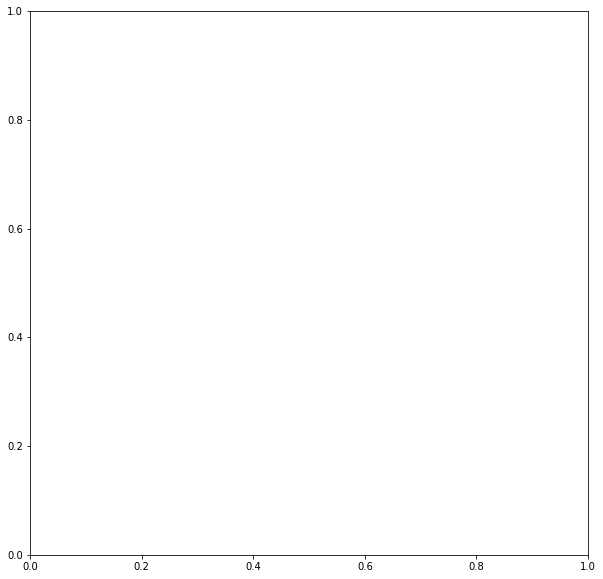

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
fig, axis = plt.subplots(figsize=(10, 10))
label_list = ['In the middle, neither yes or no', 'N/A', 'No', 'Other', 'Yes', 'Yes, subject to some conditions']
conf_mat = confusion_matrix(validation_gtruths['goldstandard2'], pred_results['goldstandard2'])
plotted = ConfusionMatrixDisplay(conf_mat, display_labels = label_list)
plotted.plot()